### Парсинг сайтов и анализ текстовой информации
Данные: раздел бытовой химии на сайте https://irecommend.ru/catalog/list/6

In [1]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
import pymorphy2
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Загрузка и проверка данных

In [3]:
# Список для хранения информации о товарах и количестве отзывов
products_info = []

# Проходим по каждой странице в категории "Красота и здоровье"
for page_num in range(0, 30):
    url = f'https://irecommend.ru/catalog/list/6?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')
    
    for product in products:
        title = product.find('div', class_='title').text
        counter = product.find('span', class_='counter').text
        products_info.append((title, counter))
        
    sleep(randint(8, 11))

In [4]:
df = pd.DataFrame(products_info, columns=['Title', 'Amount'])

In [5]:
df.head()

,Title,Amount
0,Тушь для ресниц Ив Роше / Yves Rocher «Метамор...,51
1,Гель для бровей PUSY Brow fix gel,32
2,Тональный крем Vivienne Sabo Shake Foundation ...,9
3,Крем для лица JUVELAST Intensive Night Cream,1
4,La Maison de la Vanille Vanille Fleurie de Tahiti,5


### Первичный анализ данных

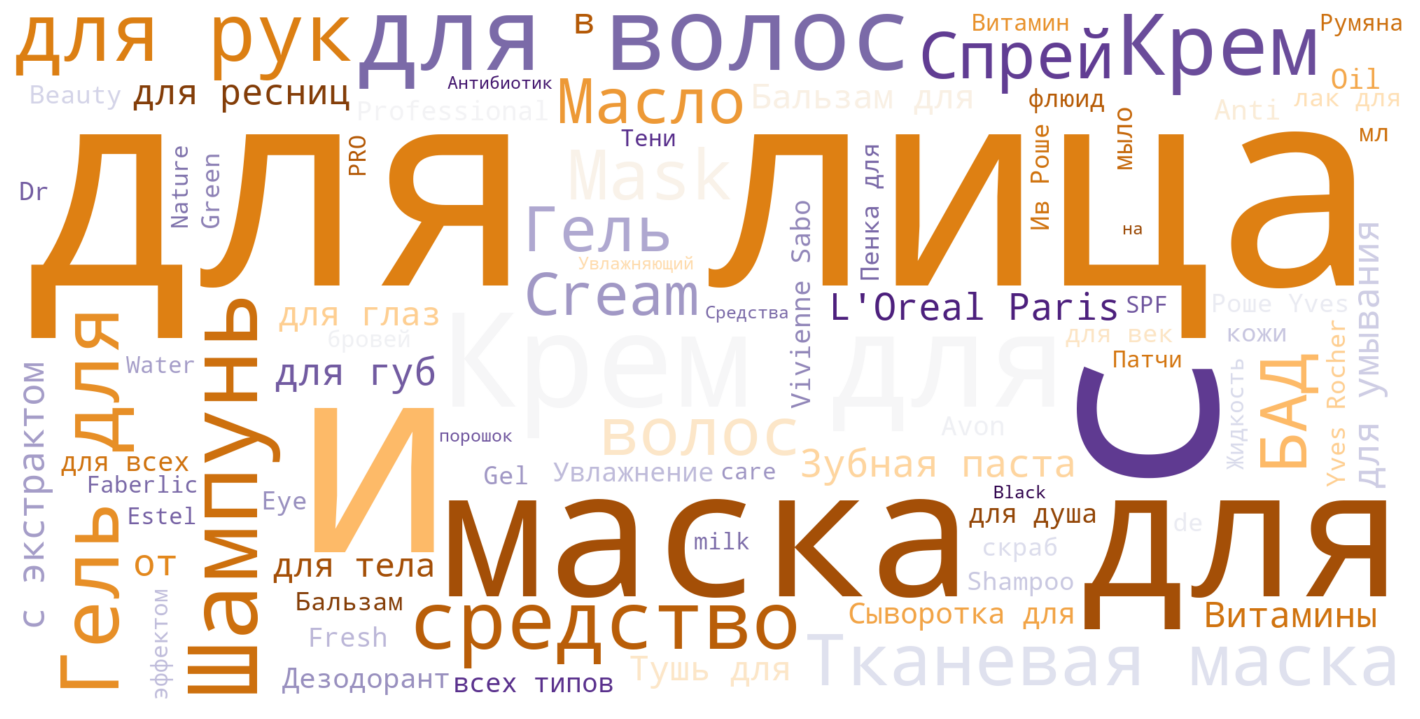

In [9]:
wordcloud = WordCloud(width=2000, height=1000, background_color='white',
                      colormap='PuOr_r', min_font_size=20, margin=15).generate(' '.join(df['Title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется предлог "для" в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов, а также привести к нормальной форме.

### Обработка данных

In [20]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("russian")

def clean_title_lemmatize(Title):
    Title = Title.lower()
    Title = re.sub(r'[^\w\s]', '', Title)
    Title = re.sub(r'\b\d+\b', '', Title)
    Title = re.sub(r'\b\w{1,2}\b', '', Title)
    words = word_tokenize(Title)
    words = [word for word in words if word not in stop_words]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [22]:
df['Title'] = df['Title'].apply(clean_title_lemmatize)

In [23]:
df.head()

,Title,Amount
0,тушь ресница рош yves rocher метаморфоза объём...,51
1,гель бровь pusy brow fix gel,32
2,тональный крем vivienne sabo shake foundation ...,9
3,крем лицо juvelast intensive night cream,1
4,maison vanille vanille fleurie tahiti,5


### Анализ после обработки

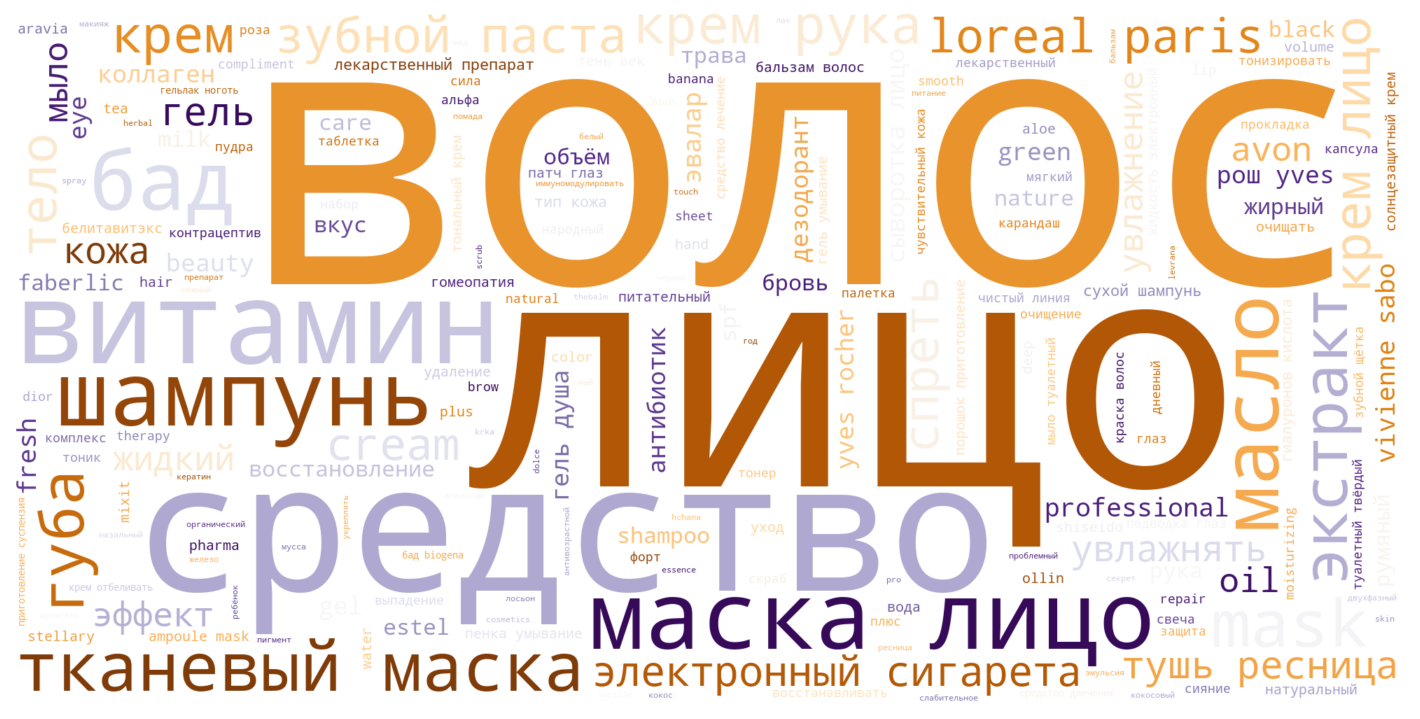

In [25]:
wordcloud = WordCloud(width=2000, height=1000, background_color='white',
                      colormap='PuOr_r', min_font_size=10, margin=15).generate(' '.join(df['Title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Нам удалось обработать текст и выделить наиболее часто встречающиеся темы, которые относятся к красоте и здоровью. Среди них можно выделить уходовую косметику, а также средства личной гигиены.

### Частотный анализ слов

In [30]:
df

,Title,Amount
0,тушь ресница рош yves rocher метаморфоза объём...,51
1,гель бровь pusy brow fix gel,32
2,тональный крем vivienne sabo shake foundation ...,9
3,крем лицо juvelast intensive night cream,1
4,maison vanille vanille fleurie tahiti,5
...,...,...
595,гель умывание librederm aevit тонизировать лицо,57
596,зубной паста colgate максимальный защита карие...,28
597,маска лицо smart angel key silver foil mask wh...,10
598,гель умывание roche posay effaclar purifying f...,1033


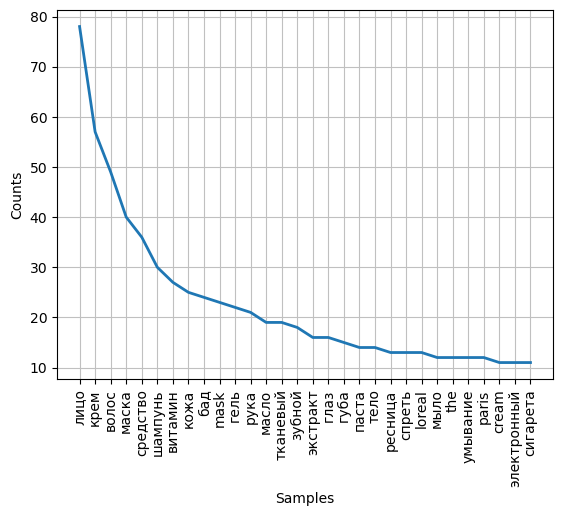

In [31]:
fdist = FreqDist()

for Title in df['Title']:
    for word in Title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Скорее всего, разделение может быть произведено по:

* Уход за кожей
* Уход за волосами
* Уход за телом
* Красота
* Средства для ухода
* Витамины
* Косметические бренды
* Электронные устройства
* Зубная гигиена

### Разделение с помощью TfidVectorizer и CountVectorizer

In [33]:
Titles = df['Title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['Title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(Titles[tfidf_clusters == i])
    print()

Cluster 1:
41       укреплять шампунь loreal paris ультра прочность
96     шампунь вьющийся волос inebrya ice cream curly...
122              шампунь levrana морошка восстанавливать
130      шампунь волос moist diane extra smooth straight
155    твёрдый шампунь green way sharme hair hemp sha...
161    шампунь свобода gamma perfect hair бессульфатн...
162            шампунь выпадение волос alerana увлажнять
167    шампунь alfaparf semi lino moisture nutritive ...
215         шампунь чистый линия natura organic шиповник
262        сухой шампунь ollin professional perfect hair
271                      шампунь pantene prov aqua light
304    шампунь zeitun ритуал восстановление сильно по...
307                       сухой шампунь batiste original
332    шампунь estel professional объём жирный волос ...
364                                шампунь vilsen яичный
376    шампунь constant delight питание сила экстракт...
383    шампунь giovanni 2chic ultrasleek shampoo braz...
397    шампунь волос

In [35]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(Titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(Titles[count_clusters == i])
    print()

Cluster 1:
165    микроигольчатый патч глаз лэтуаля эффект глубо...
289     патч глаз marshmolly золото гиалуроновый кислота
463    эликсир кожа вокруг глаз зелёный дубрава гиалу...
527    эликсир кожа вокруг глаз зелёный дубрава гиалу...
Name: Title, dtype: object

Cluster 2:
0      тушь ресница рош yves rocher метаморфоза объём...
1                           гель бровь pusy brow fix gel
4                  maison vanille vanille fleurie tahiti
5      жидкий мыло рука faberlic банановый мусса beau...
6               фотоэпилятор iluminage precise touch pro
                             ...                        
590      мыло туалетный твёрдый biomio литсеять бергамот
592            антибиотик альфа вассерманн альфа нормикс
593              шампунь daeng meo tea tree cool shampoo
595      гель умывание librederm aevit тонизировать лицо
598    гель умывание roche posay effaclar purifying f...
Name: Title, Length: 407, dtype: object

Cluster 3:
31     крем рука faberlic пантенолом увлажн

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте. Примерные его группы разбиения:

0)Уходовые средства для глаз

1)Средства личной гигиены

2)Крем для рук

3)Лекарства

4)Витамины

5)Тканевые маски

6)Зубная паста

7)Декоративная косметика

8)Солнцезащитный крем

9)Спедство лечение простуды

### Визуализация разбиения

In [36]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

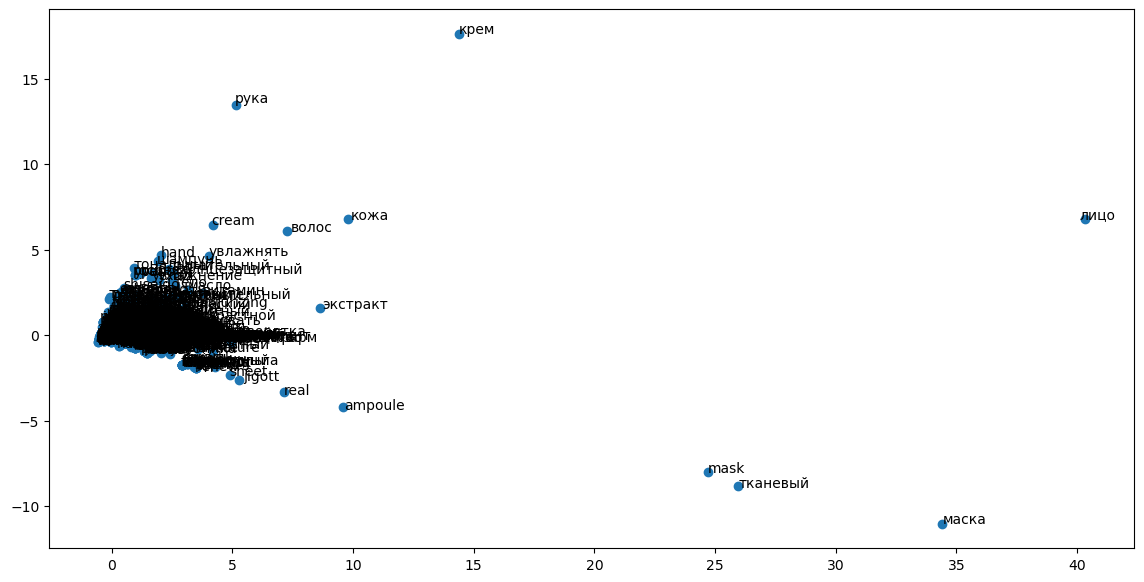

In [37]:
text_list = df['Title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


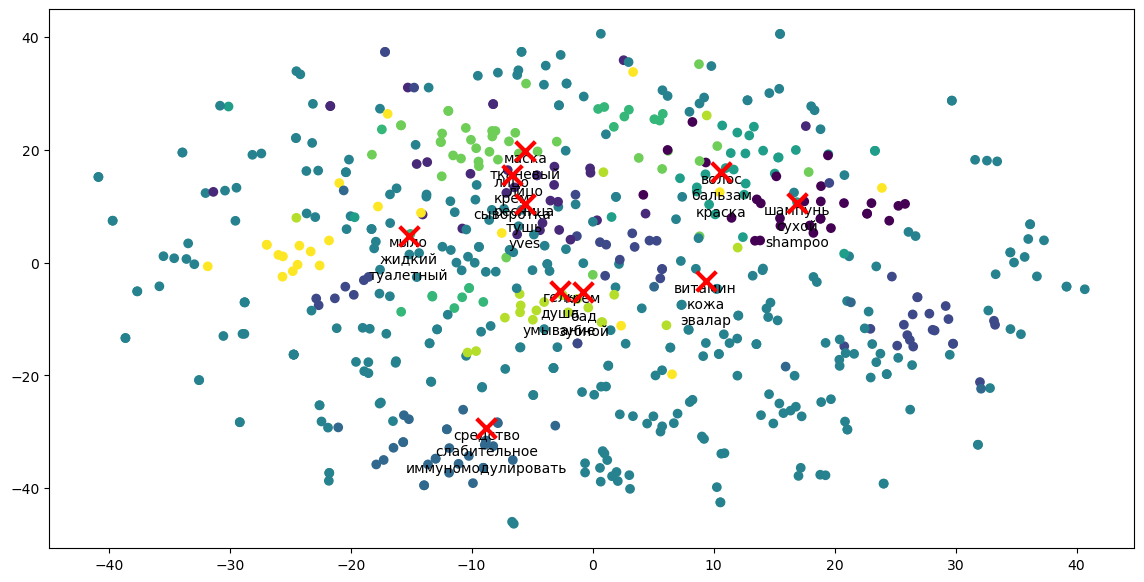

In [38]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [39]:
df['Amount'] = df['Amount'].astype(int)

df['cluster'] = tfidf_clusters

In [40]:
Title_count = df.groupby('cluster')['Title'].count()

sum_counts = df.groupby('cluster')['Amount'].sum()

stats_df = pd.concat([Title_count, sum_counts], axis=1)
stats_df.columns = ['Title_count', 'sum_counts']

stats_df

,Title_count,sum_counts
cluster,,
0,28,1748
1,31,815
2,47,2242
3,35,4108
4,330,19720
5,30,3942
6,18,1438
7,37,876
8,22,2507


Исходя из таблицы, можно сделать вывод, что товары из 4-го кластера, связанные с витаминами, наиболее популярны и пользуются наибольшей популярностью среди пользователей. Кластеры 2 (Крем для рук), 3 (Лекарства), 5 (Тканевые маски) и 8 (Солнцезащитный крем) также имеют довольно большое количество отзывов, что свидетельствует о высоком спросе на товары данных категорий. Кластеры 0 (Уходовые средства для глазн) и 6 (Зубная паста) имеют меньшее количество отзывов, что может говорить о более узкой аудитории потребителей. Остальные кластеры имеют еще меньшее количество отзывов, что может говорить о том, что данные товары пользуются меньшей популярностью или имеют более узкую целевую аудиторию.